In [96]:
import numpy as np 
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
from matplotlib import animation
from time import time


def simulate(cat_states, cat_controls, t, step_horizon, N, reference, save=False):
    def create_triangle(state=[0,0,0], h=1, w=0.5, update=False):
        x, y, th = state
        triangle = np.array([
            [h, 0   ],
            [0,  w/2],
            [0, -w/2],
            [h, 0   ]
        ]).T
        rotation_matrix = np.array([
            [cos(th), -sin(th)],
            [sin(th),  cos(th)]
        ])

        coords = np.array([[x, y]]) + (rotation_matrix @ triangle).T
        if update == True:
            return coords
        else:
            return coords[:3, :]

    def init():
        return path, horizon, current_state, target_state,

    def animate(i):
        # get variables
        x = cat_states[0, 0, i]
        y = cat_states[1, 0, i]
        th = cat_states[2, 0, i]

        # update path
        if i == 0:
            path.set_data(np.array([]), np.array([]))
        x_new = np.hstack((path.get_xdata(), x))
        y_new = np.hstack((path.get_ydata(), y))
        path.set_data(x_new, y_new)

        # update horizon
        x_new = cat_states[0, :, i]
        y_new = cat_states[1, :, i]
        horizon.set_data(x_new, y_new)

        # update current_state
        current_state.set_xy(create_triangle([x, y, th], update=True))

        # update target_state
        # xy = target_state.get_xy()
        # target_state.set_xy(xy)            

        return path, horizon, current_state, target_state,

    # create figure and axes
    fig, ax = plt.subplots(figsize=(12, 12))
    min_scale = min(reference[0], reference[1], reference[3], reference[4]) - 4
    max_scale = max(reference[0], reference[1], reference[3], reference[4]) + 4
    ax.set_xlim(left = min_scale, right = max_scale)
    ax.set_ylim(bottom = min_scale, top = max_scale)

    # create lines:
    #   path
    path, = ax.plot([], [], 'k', linewidth=2)
    #   horizon
    horizon, = ax.plot([], [], 'x-g', alpha=0.5)
    #   current_state
    current_triangle = create_triangle(reference[:3])
    current_state = ax.fill(current_triangle[:, 0], current_triangle[:, 1], color='r')
    current_state = current_state[0]
    #   target_state
    target_triangle = create_triangle(reference[3:])
    target_state = ax.fill(target_triangle[:, 0], target_triangle[:, 1], color='b')
    target_state = target_state[0]

    sim = animation.FuncAnimation(
        fig=fig,
        func=animate,
        init_func=init,
        frames=len(t),
        interval=step_horizon*100,
        blit=True,
        repeat=True
    )
    plt.show()

    if save == True:
        sim.save('./animation' + str(time()) +'.gif', writer='ffmpeg', fps=30)

    return

0
0.01851940155029297
1
0.010926961898803711
2
0.015407085418701172
3
0.04122638702392578
4
0.013309001922607422
5
0.031494855880737305
6
0.010447978973388672
7
0.014647960662841797
8
0.014049768447875977
9
0.01633620262145996
10
0.013745546340942383
11
0.01210784912109375
12
0.0130615234375
13
0.014370441436767578
14
0.015296459197998047
15
0.012813091278076172
16
0.013475179672241211
17
0.013000249862670898
18
0.012381315231323242
19
0.013644218444824219
20
0.01370382308959961
21
0.014555692672729492
22
0.015327930450439453
23
0.014316797256469727
24
0.01509237289428711
25
0.015049219131469727
26
0.01520395278930664
27
0.01553654670715332
28
0.014784812927246094
29
0.016165494918823242
30
0.016524553298950195
31
0.015743017196655273
32
0.015342235565185547
33
0.0160830020904541
34
0.016400575637817383
35
0.014738321304321289
36
0.016539812088012695
37
0.016556978225708008
38
0.015475988388061523
39
0.015333414077758789
40
0.020661592483520508
41
0.01762247085571289
42
0.0182480812072

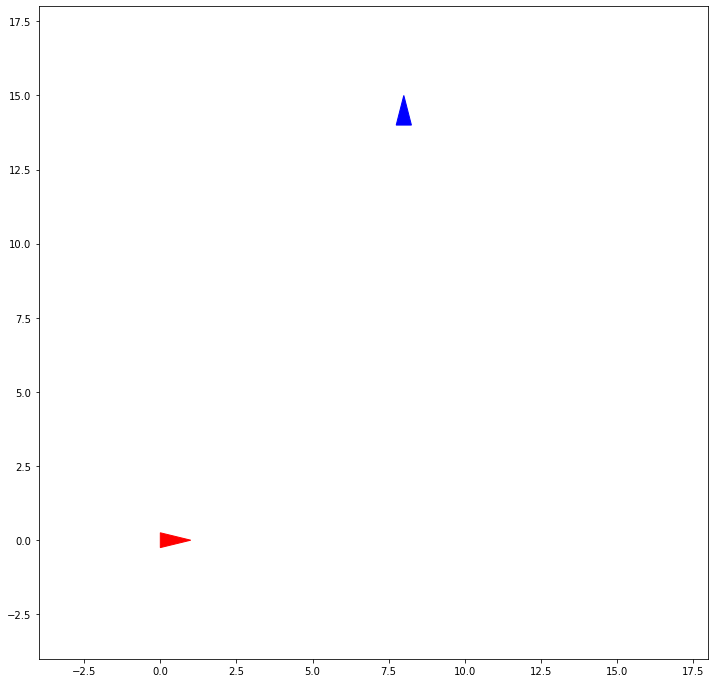

In [82]:
from time import time
import casadi as ca
import numpy as np
from casadi import sin, cos, pi
import matplotlib.pyplot as plt

# setting matrix_weights' variables
Q_x = 100
Q_y = 100
Q_theta = 2000
R1 = 1
R2 = 1
R3 = 1
R4 = 1

step_horizon = 0.1  # time between steps in seconds
N = 10              # number of look ahead steps
rob_diam = 0.3      # diameter of the robot
wheel_radius = 1    # wheel radius
Lx = 0.3            # L in J Matrix (half robot x-axis length)
Ly = 0.3            # l in J Matrix (half robot y-axis length)
sim_time = 200      # simulation time

# specs
x_init = 0
y_init = 0
theta_init = 0
x_target = 8
y_target = 14
theta_target = pi/2

v_max = 1
v_min = -1


def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))

    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0


def DM2Arr(dm):
    return np.array(dm.full())


# state symbolic variables
x = ca.SX.sym('x')
y = ca.SX.sym('y')
theta = ca.SX.sym('theta')
states = ca.vertcat(
    x,
    y,
    theta
)
n_states = states.numel()

# control symbolic variables
V_a = ca.SX.sym('V_a')
V_b = ca.SX.sym('V_b')
V_c = ca.SX.sym('V_c')
V_d = ca.SX.sym('V_d')
controls = ca.vertcat(
    V_a,
    V_b,
    V_c,
    V_d
)
n_controls = controls.numel()

# matrix containing all states over all time steps +1 (each column is a state vector)
X = ca.SX.sym('X', n_states, N + 1)

# matrix containing all control actions over all time steps (each column is an action vector)
U = ca.SX.sym('U', n_controls, N)

# coloumn vector for storing initial state and target state
P = ca.SX.sym('P', n_states + n_states)

# state weights matrix (Q_X, Q_Y, Q_THETA)
Q = ca.diagcat(Q_x, Q_y, Q_theta)

# controls weights matrix
R = ca.diagcat(R1, R2, R3, R4)

# discretization model (e.g. x2 = f(x1, v, t) = x1 + v * dt)
rot_3d_z = ca.vertcat(
    ca.horzcat(cos(theta), -sin(theta), 0),
    ca.horzcat(sin(theta),  cos(theta), 0),
    ca.horzcat(         0,           0, 1)
)
# Mecanum wheel transfer function which can be found here: 
# https://www.researchgate.net/publication/334319114_Model_Predictive_Control_for_a_Mecanum-wheeled_robot_in_Dynamical_Environments
J = (wheel_radius/4) * ca.DM([
    [         1,         1,          1,         1],
    [        -1,         1,          1,        -1],
    [-1/(Lx+Ly), 1/(Lx+Ly), -1/(Lx+Ly), 1/(Lx+Ly)]
])
# RHS = states + J @ controls * step_horizon  # Euler discretization
RHS = rot_3d_z @ J @ controls
# maps controls from [va, vb, vc, vd].T to [vx, vy, omega].T
f = ca.Function('f', [states, controls], [RHS])


cost_fn = 0  # cost function
g = X[:, 0] - P[:n_states]  # constraints in the equation


# runge kutta
for k in range(N):
    st = X[:, k]
    con = U[:, k]
    cost_fn = cost_fn \
        + (st - P[n_states:]).T @ Q @ (st - P[n_states:]) \
        + con.T @ R @ con
    st_next = X[:, k+1]
    k1 = f(st, con)
    k2 = f(st + step_horizon/2*k1, con)
    k3 = f(st + step_horizon/2*k2, con)
    k4 = f(st + step_horizon * k3, con)
    st_next_RK4 = st + (step_horizon / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    g = ca.vertcat(g, st_next - st_next_RK4)


OPT_variables = ca.vertcat(
    X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
    U.reshape((-1, 1))
)
nlp_prob = {
    'f': cost_fn,
    'x': OPT_variables,
    'g': g,
    'p': P
}

opts = {
    'ipopt': {
        'max_iter': 2000,
        'print_level': 0,
        'acceptable_tol': 1e-8,
        'acceptable_obj_change_tol': 1e-6
    },
    'print_time': 0
}

solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

lbx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))
ubx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))

lbx[0: n_states*(N+1): n_states] = -ca.inf     # X lower bound
lbx[1: n_states*(N+1): n_states] = -ca.inf     # Y lower bound
lbx[2: n_states*(N+1): n_states] = -ca.inf     # theta lower bound

ubx[0: n_states*(N+1): n_states] = ca.inf      # X upper bound
ubx[1: n_states*(N+1): n_states] = ca.inf      # Y upper bound
ubx[2: n_states*(N+1): n_states] = ca.inf      # theta upper bound

lbx[n_states*(N+1):] = v_min                  # v lower bound for all V
ubx[n_states*(N+1):] = v_max                  # v upper bound for all V


args = {
    'lbg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints lower bound
    'ubg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints upper bound
    'lbx': lbx,
    'ubx': ubx
}

t0 = 0
state_init = ca.DM([x_init, y_init, theta_init])        # initial state
state_target = ca.DM([x_target, y_target, theta_target])  # target state

# xx = DM(state_init)
t = ca.DM(t0)

u0 = ca.DM.zeros((n_controls, N))  # initial control
X0 = ca.repmat(state_init, 1, N+1)         # initial state full


mpc_iter = 0
cat_states = DM2Arr(X0)
cat_controls = DM2Arr(u0[:, 0])
times = np.array([[0]])


###############################################################################

if __name__ == '__main__':
    main_loop = time()  # return time in sec
    while (ca.norm_2(state_init - state_target) > 1e-1) and (mpc_iter * step_horizon < sim_time):
        t1 = time()
        args['p'] = ca.vertcat(
            state_init,    # current state
            state_target   # target state
        )
        # optimization variable current state
        args['x0'] = ca.vertcat(
            ca.reshape(X0, n_states*(N+1), 1),
            ca.reshape(u0, n_controls*N, 1)
        )

        sol = solver(
            x0=args['x0'],
            lbx=args['lbx'],
            ubx=args['ubx'],
            lbg=args['lbg'],
            ubg=args['ubg'],
            p=args['p']
        )

        u = ca.reshape(sol['x'][n_states * (N + 1):], n_controls, N)
        X0 = ca.reshape(sol['x'][: n_states * (N+1)], n_states, N+1)

        cat_states = np.dstack((
            cat_states,
            DM2Arr(X0)
        ))

        cat_controls = np.vstack((
            cat_controls,
            DM2Arr(u[:, 0])
        ))
        t = np.vstack((
            t,
            t0
        ))

        t0, state_init, u0 = shift_timestep(step_horizon, t0, state_init, u, f)

        # print(X0)
        X0 = ca.horzcat(
            X0[:, 1:],
            ca.reshape(X0[:, -1], -1, 1)
        )

        # xx ...
        t2 = time()
        print(mpc_iter)
        print(t2-t1)
        times = np.vstack((
            times,
            t2-t1
        ))

        mpc_iter = mpc_iter + 1

    main_loop_time = time()
    ss_error = ca.norm_2(state_init - state_target)

    print('\n\n')
    print('Total time: ', main_loop_time - main_loop)
    print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')
    print('final error: ', ss_error)

    # simulate
    simulate(cat_states, cat_controls, times, step_horizon, N,
             np.array([x_init, y_init, theta_init, x_target, y_target, theta_target]), save=True)




Total time:  10.1086266040802
avg iteration time:  84.78025428387296 ms
final error:  0.0727896


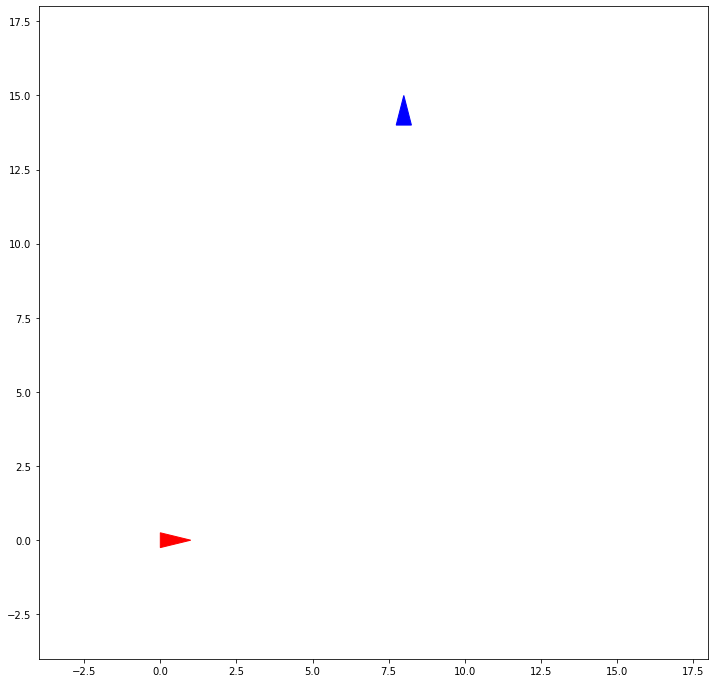

In [120]:
from time import time
import casadi as ca
import numpy as np
from casadi import sin, cos, pi
import matplotlib.pyplot as plt

mass = 1
I0 = 1

# setting matrix_weights' variables
Q_x = 10000
Q_y = 10000
Q_theta = 10000
Q_vx = 1000
Q_vy = 1000
Q_omega = 1000

R1 = 100
R2 = 100
R3 = 1
R4 = 1

step_horizon = 0.1  # time between steps in seconds
N = 40              # number of look ahead steps
rob_diam = 0.3      # diameter of the robot
wheel_radius = 1    # wheel radius
Lx = 0.3            # L in J Matrix (half robot x-axis length)
Ly = 0.3            # l in J Matrix (half robot y-axis length)
sim_time = 20      # simulation time

# specs
x_init = 0
y_init = 0
theta_init = 0
vx_init = 0
vy_init = 0
omega_init = 0

x_target = 8
y_target = 14
theta_target = pi/2
vx_target = 0
vy_target = 0
omega_target = 0

F_max = 2
F_min = -2

tau_max = 10
tau_min = -10

# v_max =  10
# v_min = -10
# v_min = 0


def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))

    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0


def DM2Arr(dm):
    return np.array(dm.full())


# state symbolic variables
# x = ca.SX.sym('x')
# y = ca.SX.sym('y')
# theta = ca.SX.sym('theta')
# states = ca.vertcat(
#     x,
#     y,
#     theta
# )

x = ca.SX.sym('x')
y = ca.SX.sym('y')
theta = ca.SX.sym('theta')
vx = ca.SX.sym('vx')
vy = ca.SX.sym('vy')
omega = ca.SX.sym('omega')
states = ca.vertcat(
    x,
    y,
    theta,
    vx,
    vy,
    omega
)
n_states = states.numel()

# control symbolic variables

# v = ca.SX.sym('v')
# omega = ca.SX.sym('omega')

# controls = ca.vertcat(
#     v,
#     omega
# )

force = ca.SX.sym('force')
tau = ca.SX.sym('tau')

controls = ca.vertcat(
    force,
    tau
)
n_controls = controls.numel()

# matrix containing all states over all time steps +1 (each column is a state vector)
X = ca.SX.sym('X', n_states, N + 1)

# matrix containing all control actions over all time steps (each column is an action vector)
U = ca.SX.sym('U', n_controls, N)

# coloumn vector for storing initial state and target state
P = ca.SX.sym('P', n_states + n_states)

# state weights matrix (Q_X, Q_Y, Q_THETA)
# Q = ca.diagcat(Q_x, Q_y, Q_theta)
Q = ca.diagcat(Q_x, Q_y, Q_theta, Q_vx, Q_vy, Q_omega)

# controls weights matrix
R = ca.diagcat(R1, R2)

# rot_3d_z = ca.vertcat(
#     ca.horzcat(cos(theta),  0),
#     ca.horzcat(sin(theta),  0),
#     ca.horzcat(         0,  1)
# )

rot_3d_z = ca.vertcat(
    ca.horzcat(0,  0),
    ca.horzcat(0,  0),
    ca.horzcat(0,  0),
    ca.horzcat(cos(theta)/mass, 0),
    ca.horzcat(sin(theta)/mass,  0),
    ca.horzcat(0,  1/I0)
)

drift = ca.vertcat(
    vx,
    vy,
    omega,
    0,
    0,
    0
)

# RHS = rot_3d_z @ controls
RHS = drift + rot_3d_z @ controls

f = ca.Function('f', [states, controls], [RHS])


cost_fn = 0  # cost function
g = X[:, 0] - P[:n_states]  # constraints in the equation


# runge kutta
for k in range(N):
    st = X[:, k]
    con = U[:, k]
    cost_fn = cost_fn \
        + (st - P[n_states:]).T @ Q @ (st - P[n_states:]) \
        + con.T @ R @ con
    st_next = X[:, k+1]
    k1 = f(st, con)
    k2 = f(st + step_horizon/2*k1, con)
    k3 = f(st + step_horizon/2*k2, con)
    k4 = f(st + step_horizon * k3, con)
    st_next_RK4 = st + (step_horizon / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    g = ca.vertcat(g, st_next - st_next_RK4)


OPT_variables = ca.vertcat(
    X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
    U.reshape((-1, 1))
)
nlp_prob = {
    'f': cost_fn,
    'x': OPT_variables,
    'g': g,
    'p': P
}

opts = {
    'ipopt': {
        'max_iter': 2000,
        'print_level': 0,
        'acceptable_tol': 1e-8,
        'acceptable_obj_change_tol': 1e-6
    },
    'print_time': 0
}

solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

lbx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))
ubx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))

lbx[0: n_states*(N+1): n_states] = -ca.inf     # X lower bound
lbx[1: n_states*(N+1): n_states] = -ca.inf     # Y lower bound
lbx[2: n_states*(N+1): n_states] = -ca.inf     # theta lower bound
lbx[3: n_states*(N+1): n_states] = -2     # VX lower bound
lbx[4: n_states*(N+1): n_states] = -2     # VY lower bound
lbx[5: n_states*(N+1): n_states] = -2     # omega lower bound

ubx[0: n_states*(N+1): n_states] = ca.inf      # X upper bound
ubx[1: n_states*(N+1): n_states] = ca.inf      # Y upper bound
ubx[2: n_states*(N+1): n_states] = ca.inf      # theta upper bound
ubx[3: n_states*(N+1): n_states] = 2      # VX upper bound
ubx[4: n_states*(N+1): n_states] = 2      # VY upper bound
ubx[5: n_states*(N+1): n_states] = 2      # omega upper bound

lbx[n_states*(N+1)::2] = F_min                 # force lower bound
lbx[n_states*(N+1)+1::2] = tau_min             # tau lower bound 

ubx[n_states*(N+1)::2] = F_max                  # v upper bound for all V
ubx[n_states*(N+1)+1::2] = tau_max                  # v upper bound for all V


args = {
    'lbg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints lower bound
    'ubg': ca.DM.zeros((n_states*(N+1), 1)),  # constraints upper bound
    'lbx': lbx,
    'ubx': ubx
}

t0 = 0
# state_init = ca.DM([x_init, y_init, theta_init])        # initial state
# state_target = ca.DM([x_target, y_target, theta_target])  # target state
state_init = ca.DM([x_init, y_init, theta_init, vx_init, vy_init, omega_init])        # initial state
state_target = ca.DM([x_target, y_target, theta_target, vx_target, vy_target, omega_target])  # target state

# xx = DM(state_init)
t = ca.DM(t0)

u0 = ca.DM.zeros((n_controls, N))  # initial control
X0 = ca.repmat(state_init, 1, N+1)         # initial state full


mpc_iter = 0
cat_states = DM2Arr(X0)
cat_controls = DM2Arr(u0[:, 0])
times = np.array([[0]])


###############################################################################

if __name__ == '__main__':
    main_loop = time()  # return time in sec
    while (ca.norm_2(state_init - state_target) > 1e-1) and (mpc_iter * step_horizon < sim_time):
        t1 = time()
        args['p'] = ca.vertcat(
            state_init,    # current state
            state_target   # target state
        )
        # optimization variable current state
        args['x0'] = ca.vertcat(
            ca.reshape(X0, n_states*(N+1), 1),
            ca.reshape(u0, n_controls*N, 1)
        )

        sol = solver(
            x0=args['x0'],
            lbx=args['lbx'],
            ubx=args['ubx'],
            lbg=args['lbg'],
            ubg=args['ubg'],
            p=args['p']
        )

        u = ca.reshape(sol['x'][n_states * (N + 1):], n_controls, N)
        X0 = ca.reshape(sol['x'][: n_states * (N+1)], n_states, N+1)
        cat_states = np.dstack((
            cat_states,
            DM2Arr(X0)
        ))
        # print('u',u[:, 0])
        cat_controls = np.vstack((
            cat_controls,
            DM2Arr(u[:, 0])
        ))
        t = np.vstack((
            t,
            t0
        ))

        t0, state_init, u0 = shift_timestep(step_horizon, t0, state_init, u, f)

        # print(X0)
        X0 = ca.horzcat(
            X0[:, 1:],
            ca.reshape(X0[:, -1], -1, 1)
        )

        # xx ...
        t2 = time()
        # print(mpc_iter)
        # print(t2-t1)
        times = np.vstack((
            times,
            t2-t1
        ))

        mpc_iter = mpc_iter + 1

    main_loop_time = time()
    ss_error = ca.norm_2(state_init - state_target)

    print('\n\n')
    print('Total time: ', main_loop_time - main_loop)
    print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')
    print('final error: ', ss_error)

    # simulate
    simulate(cat_states, cat_controls, times, step_horizon, N,
             np.array([x_init, y_init, theta_init, x_target, y_target, theta_target]), save=True)

In [78]:
lbx[n_states*(N+1)-1::2] 

DM([-inf, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10])

In [52]:
print(states)
print(RHS)

cat_states.shape

[x, y, theta, vx, vy, omega]
[vx, vy, omega, (cos(theta)*force), (sin(theta)*force), (0.5*tau)]


(6, 11, 101)